In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, to_timestamp, year, month,
    dayofmonth, hour, date_format,
    dayofweek, when
)
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

spark = (SparkSession.builder
    .appName("MTA Subway Hourly Ridership Preprocessing")
    .master("local[*]")
    .config("spark.driver.memory", "6g")
    .getOrCreate()
)

raw = (spark.read
    .option("header", True)
    .option("inferSchema", True)   # <-- brings in all columns, including station_complex and station_complex_id
    .csv("/Users/rons/Desktop/Big Data/MTASubwayHourlyRidership_2020-2024.csv")
)

df = (raw
    .withColumn("ts", to_timestamp(col("transit_timestamp"), "MM/dd/yyyy hh:mm:ss a"))
    .na.drop(subset=["ts", "ridership"])
    # now drop dupes on the true unique key
    .dropDuplicates(subset=["transit_timestamp", "station_complex_id"])
    .withColumn("ridership",   col("ridership").cast("long"))
    .withColumn("transfers",   col("transfers").cast("long"))
    .withColumn("latitude",    col("latitude").cast("double"))
    .withColumn("longitude",   col("longitude").cast("double"))
    .withColumn("year",        year(col("ts")))
    .withColumn("month",       month(col("ts")))
    .withColumn("day",         dayofmonth(col("ts")))
    .withColumn("hour",        hour(col("ts")))
    .withColumn("weekday",     date_format(col("ts"), "E"))
    .withColumn("is_weekend",  when(dayofweek(col("ts")).isin(1,7), 1).otherwise(0))
)

# Index everything in one shot
categoricals = [
    "transit_mode", "borough",
    "payment_method", "fare_class_category",
    "station_complex"
]
indexers = [
    StringIndexer(inputCol=cat, outputCol=f"{cat}_idx", handleInvalid="keep")
    for cat in categoricals
]
df = Pipeline(stages=indexers).fit(df).transform(df)

# Filter, persist, and write compact parquet
df = df.filter((col("year") >= 2020) & (col("year") <= 2024)).persist()
df.coalesce(20).write.mode("overwrite") \
  .parquet("/Users/rons/Desktop/Big Data/processed/mta_hourly_features.parquet")

spark.stop()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/04 12:45:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


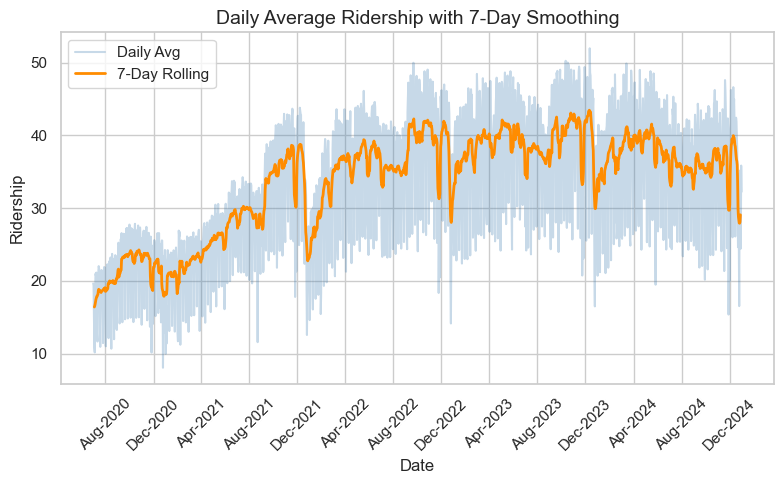

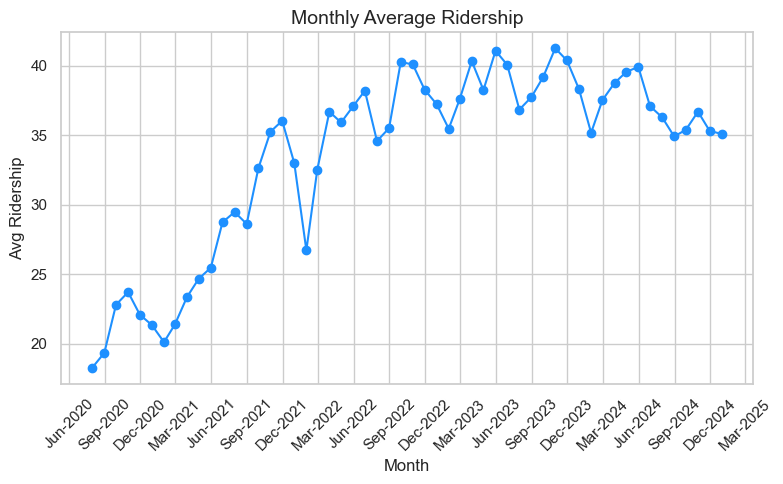

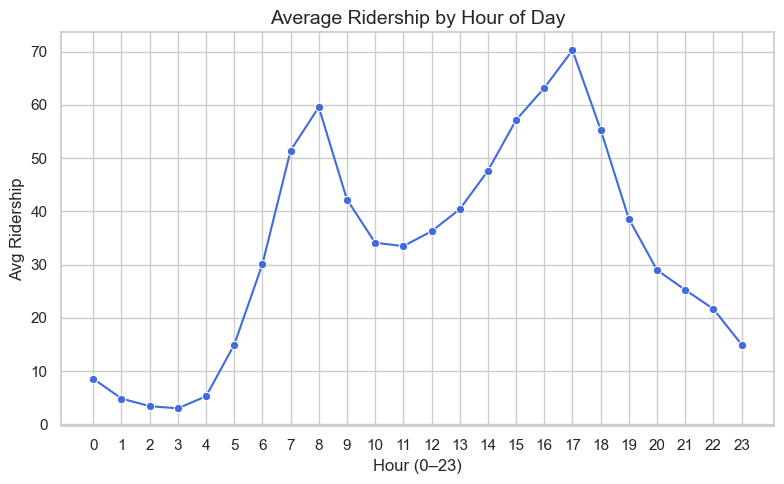

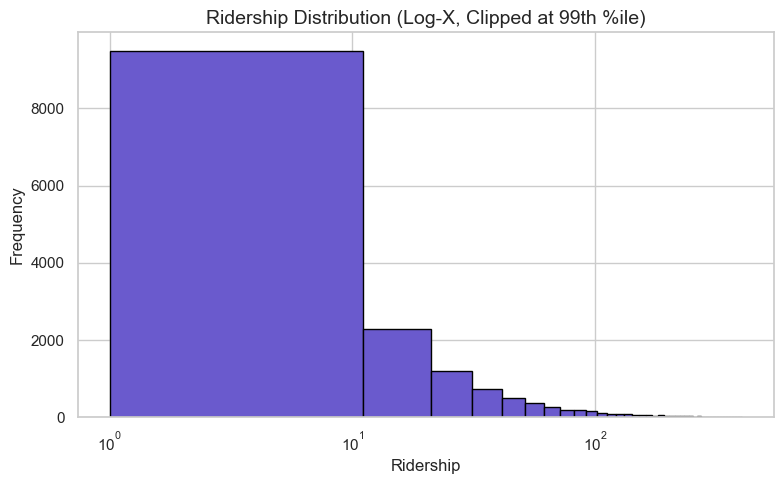

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates

# Set global style
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams.update({"figure.figsize": (8, 5), "axes.titlesize": 14, "axes.labelsize": 12})

# === A) Daily + Rolling ===
fig, ax = plt.subplots()
ax.plot(pdf_daily.index, pdf_daily["daily_avg"], alpha=0.3, label="Daily Avg", color="steelblue")
ax.plot(pdf_daily.index, pdf_daily["roll7"], label="7-Day Rolling", color="darkorange", linewidth=2)

# Improve date axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
plt.xticks(rotation=45)
ax.set_title("Daily Average Ridership with 7-Day Smoothing")
ax.set_xlabel("Date")
ax.set_ylabel("Ridership")
ax.legend()
plt.tight_layout()
plt.show()

# === B) Monthly Average ===
fig, ax = plt.subplots()
ax.plot(pdf_monthly.index, pdf_monthly.values, marker="o", linestyle="-", color="dodgerblue")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
plt.xticks(rotation=45)
ax.set_title("Monthly Average Ridership")
ax.set_xlabel("Month")
ax.set_ylabel("Avg Ridership")
plt.tight_layout()
plt.show()

# === C) Hour-of-Day Profile ===
fig, ax = plt.subplots()
sns.lineplot(data=pdf_hourly, x="hour", y="avg_by_hour", marker="o", ax=ax, color="royalblue")
ax.set_title("Average Ridership by Hour of Day")
ax.set_xlabel("Hour (0–23)")
ax.set_ylabel("Avg Ridership")
ax.set_xticks(range(0, 24))
plt.tight_layout()
plt.show()

# === D) Histogram with Log X ===
fig, ax = plt.subplots()
clip_val = sample_pd.quantile(0.99)
clipped = sample_pd[sample_pd < clip_val]

ax.hist(clipped, bins=40, color="slateblue", edgecolor="black")
ax.set_xscale("log")
ax.set_title("Ridership Distribution (Log-X, Clipped at 99th %ile)")
ax.set_xlabel("Ridership")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()


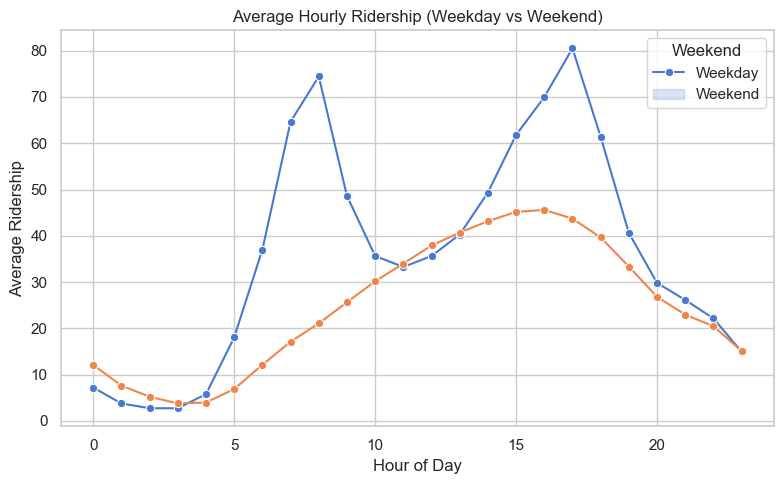

In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Start Spark session
spark = SparkSession.builder \
    .appName("MTA Hourly Profile Plot") \
    .master("local[*]") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()

# 2. Load data
df = spark.read.parquet("/Users/rons/Desktop/Big Data/processed/mta_hourly_features.parquet") \
               .select("hour", "is_weekend", "ridership", "year") \
               .filter((col("year") >= 2020) & (col("year") <= 2024))

# 3. Group by hour and weekend flag
peak_df = df.groupBy("hour", "is_weekend") \
            .agg(avg("ridership").alias("avg_ridership")) \
            .orderBy("hour", "is_weekend") \
            .toPandas()

# 4. Plot using seaborn
sns.set_theme(style="whitegrid", palette="muted")
plt.figure(figsize=(8, 5))
sns.lineplot(data=peak_df, x="hour", y="avg_ridership", hue="is_weekend", marker="o")
plt.title("Average Hourly Ridership (Weekday vs Weekend)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Ridership")
plt.legend(title="Weekend", labels=["Weekday", "Weekend"])
plt.tight_layout()
plt.show()

# 5. Stop Spark
spark.stop()


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder \
    .appName("MTA Correlation Heatmap") \
    .master("local[*]") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()

df = spark.read.parquet("/Users/rons/Desktop/Big Data/processed/mta_hourly_features.parquet")

numeric_cols = [
    "ridership", "transfers", "latitude", "longitude",
    "hour", "day", "month", "year", "is_weekend",
    "transit_mode_idx", "borough_idx", "station_complex_idx",
    "fare_class_category_idx", "payment_method_idx"
]

# Sample a manageable subset for local correlation analysis
sampled_df = df.select(*numeric_cols).sample(False, 0.01, seed=42)
pdf = sampled_df.toPandas()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/04 13:40:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


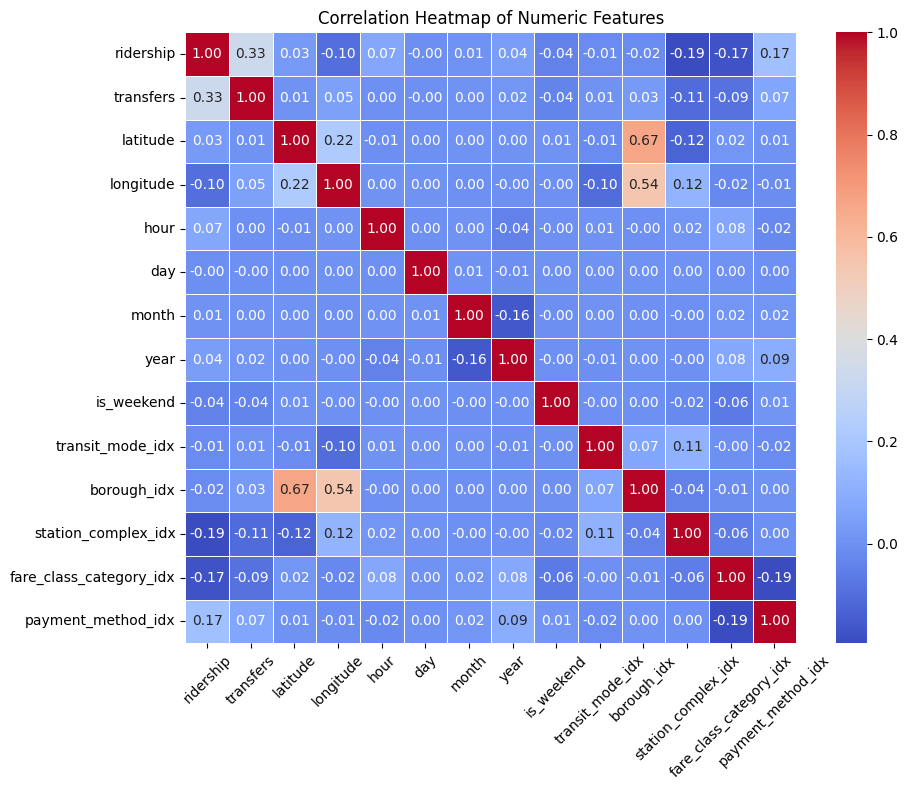

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = pdf.corr(numeric_only=True)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()